Epoch [1/5], Step [100/600], Loss: 0.2344
Epoch [1/5], Step [200/600], Loss: 0.0666
Epoch [1/5], Step [300/600], Loss: 0.0987
Epoch [1/5], Step [400/600], Loss: 0.0859
Epoch [1/5], Step [500/600], Loss: 0.0846
Epoch [1/5], Step [600/600], Loss: 0.0564
Epoch [2/5], Step [100/600], Loss: 0.0782
Epoch [2/5], Step [200/600], Loss: 0.0541
Epoch [2/5], Step [300/600], Loss: 0.0930
Epoch [2/5], Step [400/600], Loss: 0.0731
Epoch [2/5], Step [500/600], Loss: 0.0320
Epoch [2/5], Step [600/600], Loss: 0.0190
Epoch [3/5], Step [100/600], Loss: 0.0793
Epoch [3/5], Step [200/600], Loss: 0.0150
Epoch [3/5], Step [300/600], Loss: 0.0079
Epoch [3/5], Step [400/600], Loss: 0.0228
Epoch [3/5], Step [500/600], Loss: 0.0331
Epoch [3/5], Step [600/600], Loss: 0.0318
Epoch [4/5], Step [100/600], Loss: 0.0141
Epoch [4/5], Step [200/600], Loss: 0.0213
Epoch [4/5], Step [300/600], Loss: 0.0053
Epoch [4/5], Step [400/600], Loss: 0.0783
Epoch [4/5], Step [500/600], Loss: 0.0274
Epoch [4/5], Step [600/600], Loss:

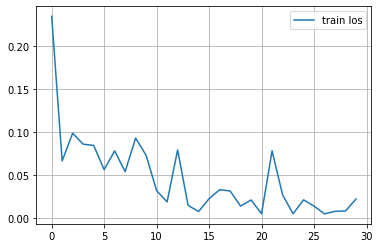

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        nn.init.kaiming_normal_(self.fc.weight) ## He Initializer
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_log = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # Clear gradients w.r.t. parameters
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_log.append(loss.item())
            
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

plt.plot(train_log,label='train los')
plt.legend(loc='best')
plt.grid()
plt.show()